In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import yaml
import argparse


In [ ]:
def plot_rcm(RC_matrix, cfg_file):
    
    with open(cfg_file, 'r') as file:
        config = yaml.safe_load(file)

    title = config.get("title")
    variable_name = config.get("variable_name")
    fig_height = config.get("fig_height")
    fig_width = config.get("fig_width")

    add_clock_label = config.get("add_clock_label")
    t_count = config.get("t_count")
    t_label = config.get("t_label")
    t_steps_to_label = config.get("t_steps_to_label")

    colormap_name = config.get("colormap_name")
    normalize = config.get("normalize")
    cmax = config.get("cmax")
    cmin = config.get("cmin")
    threshold = config.get("threshold")

    x_prefix = config.get("x_prefix")
    y_prefix = config.get("y_prefix")
    add_axis_labels_from_list = config.get("add_axis_labels_from_list")
    x_prefix_list = config.get("x_prefix_list")
    y_prefix_list = config.get("y_prefix_list")

    diagonal_label_type = config.get("diagonal_label_type")
    single_diagonal_prefix = config.get("single_diagonal_prefix")
    diagonal_label_color = config.get("diagonal_label_color")

    """ 
    Generates an RCM plot from the given data.
    
    Prepare your data to be a data cube with the following structure:
    `RC_matrix[time_dimension, y_dimension, x_dimension]`

    See `rcm_settins.yaml` file for inputs.

    Zafer Defne 6/24/2025
    """

    if normalize == True:
        norm = Normalize(vmin=cmin, vmax=cmax)
    else:
        norm = Normalize()

    if threshold != "":
        print(f"Threshold is set to : {threshold}")
    cmap = plt.get_cmap(colormap_name)

    # Clock and matrix dimensions
    t_count = RC_matrix.shape[0]
    theta = np.linspace(0, 2*np.pi, t_count + 1)

    y_count = RC_matrix.shape[1]
    x_count = RC_matrix.shape[2]

    fig, axs = plt.subplots(y_count, x_count, subplot_kw={'projection': 'polar'}, figsize=(fig_width, fig_height))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for si in range(y_count):        # source (rows)
        for di in range(x_count):    # destination (columns)
            ax = axs[si, di]
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(0, 1)
            if si == di:
                ax.set_facecolor([0.5, 0.5, 0.5])
            else:
                ax.set_facecolor([0.8, 0.8, 0.8])

            P = RC_matrix[:, si, di]

            if threshold != "" or np.nanmax(P) > threshold:
                for i in range(t_count):
                    val = P[i]
                    if not np.isnan(val):
                        ax.bar(
                            x=theta[i],
                            height=1,
                            width=theta[i+1] - theta[i],
                            bottom=0,
                            color=cmap(norm(val)),
                            align='edge'
                        )
                        if di == 0 and si == 0 and i in t_steps_to_label:
                            ax.text(theta[i], 0.75, f"{t_label} \n {i}", 
                                    ha='center', va='center', fontsize=10)
            
            if add_axis_labels_from_list == True:
                x_label = x_prefix_list[di]
                y_label = y_prefix_list[si]
                diagonal_label_type = "None"
            else:
                x_label = f"{x_prefix} {di+1}"
                y_label = f"{y_prefix} {si+1}"

            # Y-axis label (source polygons)
            if di == 0:
                ax.annotate(y_label, xy=(-0.1, 0.5), xycoords='axes fraction',
                            ha='right', va='center', fontsize=12, rotation=90)

            # X-axis label (destination polygons)
            if si == y_count - 1:
                ax.annotate(x_label, xy=(0.5, -0.1), xycoords='axes fraction',
                            ha='center', va='top', fontsize=12)



            # Diagonal tile label
            if diagonal_label_type == "Default":
                diagonal_label = f"{y_prefix} {si + 1}, {x_prefix} {di + 1}"
            elif diagonal_label_type == "Single":
                diagonal_label = f"{single_diagonal_prefix} {si + 1}"
            else:
                diagonal_label_type == "None"

            if diagonal_label_type != "None":
                if si == di:
                    ax.text(0, 0, diagonal_label, ha="center", va="center", fontsize=10, color = diagonal_label_color)

    # Add colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axs.ravel().tolist(), fraction=0.025, pad=0.01).set_label(variable_name, fontsize = 10)

    fig.suptitle(title, x=0.5, y=0.92, fontsize=14)
    plt.show()
    return fig


Threshold is set to : 0.001


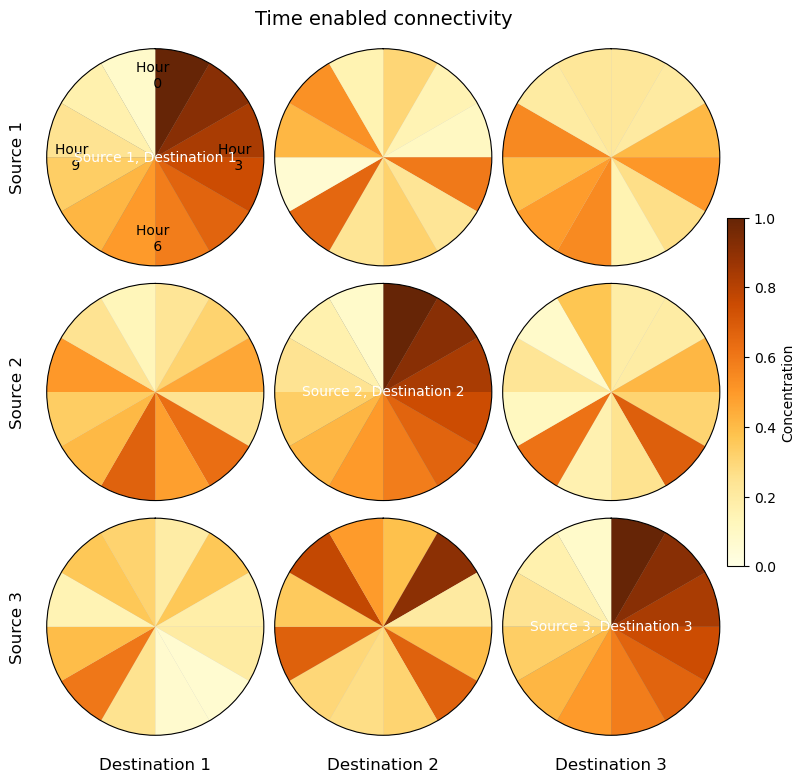

In [ ]:
# cfg_file = "rcm_config_concentration.yaml"  # concentration example
# rcm_test= np.random.lognormal(mean=-1.2, sigma=.7, size=(12, 3, 3)) / np.max(rcm_test) # shape: (num_timesteps, Y, X)
# rcm_test[:,0,0] = np.arange(1, 0, -1/12)
# rcm_test[:,1,1] = np.arange(1, 0, -1/12)
# rcm_test[:,2,2] = np.arange(1, 0, -1/12)
# fig_file="sample_output_concentration.png"

cfg_file = "rcm_config_correlation.yaml"    # correlation example
rcm_test= np.random.lognormal(mean=-1.2, sigma=.7, size=(12, 3, 4)) * 2 -1 # shape: (num_timesteps, Y, X)
fig_file="sample_output_correlation.png"

# cfg_file = "rcm_cfg.yaml"    # correlation example

sample_out = plot_rcm(rcm_test, cfg_file)

sample_out.savefig(fig_file)

In [93]:
# # This part is for running from command line (but not sure if it is useful, so stopped developing for now)
# if __name__=="__main__":
#     parser = argparse.ArgumentParser(description="Generate a Relation Clock Matrix (RCM) plot.")
#     parser.add_argument("--rcm", default ="rcm", help = "Matrix of data to plot. rcm[time, ,y ,x,]")
#     parser.add_argument("--cfg", default ="rcm_cfg.yaml", help = "Configuration file figure settings")
#     parser.add_argument("--fig", default="RCM_plot.png", help="File name for the figure")

#     args = parser.parse_args()

#     sample_out = plot_rcm(args.rcm, args.cfg)
    
#     sample_out.savefig(args.fig)

